In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
import random


def reset_numpy_seed(seed_value=42):
  try:
    # Set NumPy random seed
    import numpy as np
    np.random.seed(seed_value)
    print(f'NumPy random seed set with value: {seed_value}')
  except Exception as e:
    print(f'NumPy random seed was not set: {e}')
  return

def reset_torch_seed(seed_value=42):
  try:
    import torch
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed_value)
    print(f'PyTorch random seed set with value: {seed_value}')
  except Exception as e:
    print(f'PyTorch random seed was not set: {e}')
  return


def set_random_seeds(seed_value=42):
  # Set Python random seed
  random.seed(seed_value)
  reset_numpy_seed(seed_value)
  reset_torch_seed(seed_value)
  return


if __name__ == '__main__':
  # Set the desired seed value
  seed = 42

  # Set random seeds
  set_random_seeds(seed)

NumPy random seed set with value: 42
PyTorch random seed set with value: 42


In [3]:
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cuda")

In [4]:
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

In [5]:
beta

tensor(0.8187)

In [6]:
batch_size = 64
num_steps = 10
data_path='/tmp/data/mnist'

dtype = torch.float

In [7]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
spike_grad = surrogate.fast_sigmoid(slope=25)

In [9]:
# net = nn.Sequential(
#     nn.Conv2d(1, 12, 5),  # Input: (128, 1, 28, 28), Output: (128, 12, 24, 24)
#     nn.MaxPool2d(2),       # Output: (128, 12, 12, 12)
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),  # Output: (128, 12, 12, 12)
#     nn.Conv2d(12, 64, 5),  # Output: (128, 64, 8, 8)
#     nn.MaxPool2d(2),       # Output: (128, 64, 4, 4)
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),  # Output: (128, 64, 4, 4)
#     nn.Flatten(),          # Output: (128, 1024)
#     nn.Linear(64*4*4, 10), # Output: (128, 10)
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)  # Output: (128, 10)
# ).to(device)

net = nn.Sequential(
    nn.Conv2d(1, 12, 5),  
    nn.MaxPool2d(2),       
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True),  
    nn.Conv2d(12, 64, 5),  
    nn.MaxPool2d(2),       
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True), 
    nn.Conv2d(64, 128, 3), 
    nn.MaxPool2d(2),       
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True),  
    nn.Flatten(),          
    nn.Linear(128, 10),  
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, learn_beta=True, output=True)
).to(device)

In [10]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [11]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [12]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [13]:
loss_fn = SF.ce_rate_loss()
loss_val = loss_fn(spk_rec, targets)
acc = SF.accuracy_rate(spk_rec, targets)

In [14]:
print(f"The loss from an untrained network is {loss_val.item():.3f}")
print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The loss from an untrained network is 2.303
The accuracy of a single batch using an untrained network is 10.938%


In [15]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [16]:
test_acc = batch_accuracy(test_loader, net, num_steps)
print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.80%


In [17]:
# for i in range(128):
#     if torch.sum(spk_rec[:, i, :]) > 0:
#         print(i)

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
num_epochs = 3
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 100 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

with torch.no_grad():
    net.eval()

    # Test set forward pass
    test_acc = batch_accuracy(test_loader, net, num_steps)
    print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
    test_acc_hist.append(test_acc.item())

Iteration 0, Test Acc: 9.80%

Iteration 100, Test Acc: 81.15%

Iteration 200, Test Acc: 90.44%

Iteration 300, Test Acc: 95.19%

Iteration 400, Test Acc: 95.44%

Iteration 500, Test Acc: 95.77%

Iteration 600, Test Acc: 96.82%

Iteration 700, Test Acc: 97.27%

Iteration 800, Test Acc: 97.58%

Iteration 900, Test Acc: 97.38%

Iteration 1000, Test Acc: 97.57%

Iteration 1100, Test Acc: 97.66%

Iteration 1200, Test Acc: 98.12%

Iteration 1300, Test Acc: 97.64%

Iteration 1400, Test Acc: 97.88%

Iteration 1500, Test Acc: 97.89%

Iteration 1600, Test Acc: 98.17%

Iteration 1700, Test Acc: 98.08%

Iteration 1800, Test Acc: 98.06%

Iteration 1900, Test Acc: 98.06%

Iteration 2000, Test Acc: 98.08%

Iteration 2100, Test Acc: 98.04%

Iteration 2200, Test Acc: 98.19%

Iteration 2300, Test Acc: 98.18%

Iteration 2400, Test Acc: 97.86%

Iteration 2500, Test Acc: 98.14%

Iteration 2600, Test Acc: 98.26%

Iteration 2700, Test Acc: 98.35%

Iteration 2800, Test Acc: 98.07%

Iteration 2811, Test Acc: 9

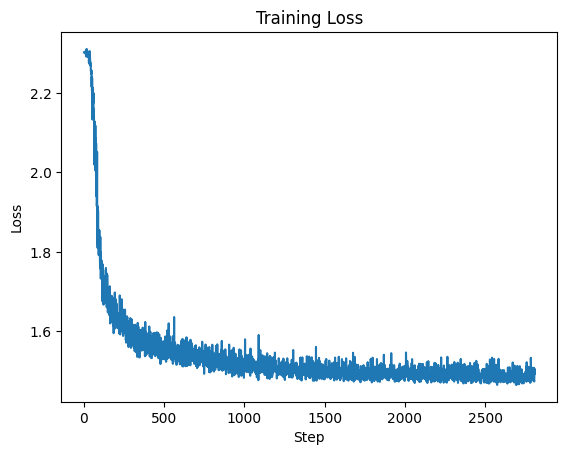

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

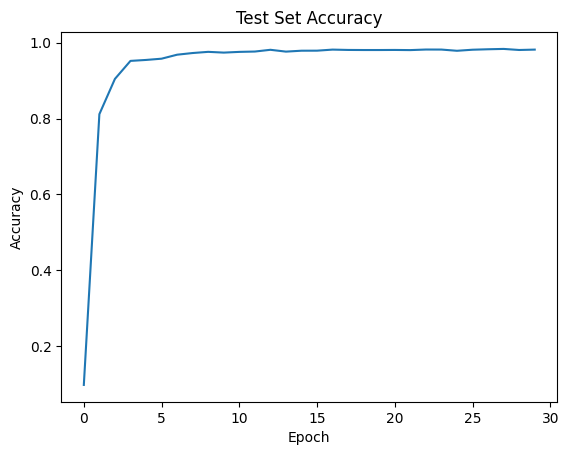

In [20]:

fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [21]:
# from IPython.display import HTML

# idx = 2

# fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
# labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

# plt.rcParams['animation.ffmpeg_path'] = 'C:/ffmpeg/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe'

# anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
#                         animate=True, interpolate=4)

# print(f"The target label is: {targets[idx]}")
# HTML(anim.to_html5_video())